In [26]:
import planetary_computer
import dask_gateway
import dask.dataframe as dd
import pystac_client
import operator
import datashader as ds, datashader.transfer_functions as tf, numpy as np
from functools import partial
from datashader.utils import export_image
from datashader.colors import colormap_select, Greys9
from IPython.core.display import HTML, display
from colorcet import fire

In [12]:
item = pystac.read_file("https://planetarycomputer-staging.microsoft.com/api/stac/v1/collections/gbif/items/gbif-2021-09-01")

In [17]:
signed_item = planetary_computer.sign(item)
asset = signed_item.assets["data"]

In [21]:
df = dd.read_parquet(
    asset.href, engine="pyarrow",
    storage_options=asset.extra_fields["table:storage_options"],
    columns=["decimallongitude", "decimallatitude"])
df

,decimallongitude,decimallatitude
npartitions=1034,,
,float64,float64
,...,...
...,...,...
,...,...
,...,...


In [68]:
%%time
df2 = df[(df.decimallongitude > -100.85) & (df.decimallongitude < -33.75) & (df.decimallatitude > -23.165) & (df.decimallatitude < 5.013)]
# df3 = dd.concat([df2.get_partition(i) for i in range(50)]).compute()
df3 = df2.compute()

CPU times: user 3min 19s, sys: 47 s, total: 4min 6s
Wall time: 4min 24s


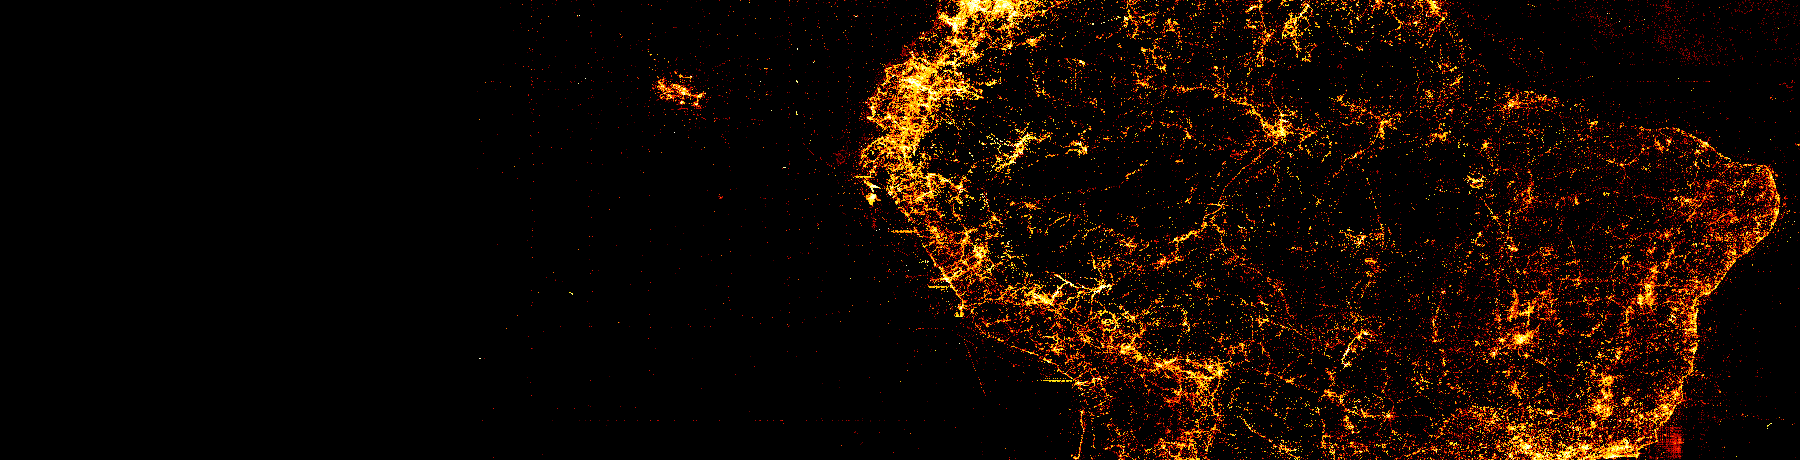

In [71]:
w = 1800
# h = int(w / (16 / 9))
h = 460

cvs = ds.Canvas(w, h, x_range=(-125, -33.75))
agg = cvs.points(df3, 'decimallongitude', 'decimallatitude')

img = tf.set_background(tf.shade(agg, cmap=fire), "black")
img

In [74]:
p = img.to_pil().save("gbif-hero.png")